In [1]:
import torch
import intel_extension_for_pytorch as ipex
from torch import nn as nn
from torch import Tensor
import math
from glob import glob
from torchinfo import summary
from torch_snippets import *
from torch_snippets.torch_loader import Report
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.data import WeightedRandomSampler
from torchvision import transforms
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import cohen_kappa_score
from PIL import Image 

#is GPU available?
gpu = torch.cuda.is_available()

#defining device where to to the computation
device = torch.device(0) if gpu else torch.device('cpu')

print(f'Using device: {device}')

/home/pedro/Repositories/dl-larvae/.venv/lib/python3.12/site-packages/intel_extension_for_pytorch/transformers/optimize.py:4: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
[W704 18:15:21.056789491 OperatorEntry.cpp:154] Warning: Warning only once for all operators,  other operators may also be overridden.
  Overriding a previously registered kernel for the same operator and the same dispatch key
  operator: aten::_addmm_activation(Tensor self, Tensor mat1, Tensor mat2, *, Scalar beta=1, Scalar alpha=1, bool use_gelu=False) -> Tensor
    registered at /pytorch/build/aten/src/ATen/RegisterSchema.cpp:6
  dispatch key: AutocastCPU
  previous kernel: registered at /pytorch/aten/src/ATen/autocast_mode.cpp:327
       new kernel: registered at /opt/workspace/ipex-cpu-dev/csrc/cp

Using device: cpu


### Randomly split a fileset into training, validation, and test sets: output lists of image names

In [102]:
from glob import glob
import os

# Parameters
orig_dir = '../images'
train_perc, valid_perc, test_perc = 0.10, 0.05, 0.05
width, height, nchannels = 224, 224, 3
nclasses = 2  # larvae and residue
input_shape = (nchannels, height, width)
model_name = 'LarvaeCNN.pth'

larvae_train_perc = 0.10
larvae_valid_perc = 0.10
larvae_test_perc = 0.10

residue_train_perc = 0.02
residue_valid_perc = 0.02
residue_test_perc = 0.02

# Load images by class
larvae_files = glob(os.path.join(orig_dir, 'larvae', '*.png'))
residue_files = glob(os.path.join(orig_dir, 'residue', '*.png'))

# Shuffle each class
np.random.shuffle(larvae_files)
np.random.shuffle(residue_files)

# Split each class
num_train_larvae = int(len(larvae_files) * larvae_train_perc)
num_valid_larvae = int(len(larvae_files) * larvae_valid_perc)
num_test_larvae = int(len(larvae_files) * larvae_test_perc)

print(f"Number of train larvae images: {num_train_larvae}")
print(f"Number of validation larvae images: {num_valid_larvae}")
print(f"Number of test larvae images: {num_test_larvae}")

num_train_residue = int(len(residue_files) * residue_train_perc)
num_valid_residue = int(len(residue_files) * residue_valid_perc)
num_test_residue = int(len(residue_files) * residue_test_perc)
print("------------------------------------------")
print(f"Number of train residue images: {num_train_residue}")
print(f"Number of validation residue images: {num_valid_residue}")
print(f"Number of test residue images: {num_test_residue}")
print("------------------------------------------")

# Create train, validation, and test sets
trainset = larvae_files[:num_train_larvae] + residue_files[:num_train_residue]
validset = larvae_files[num_train_larvae:num_train_larvae + num_valid_larvae] + \
           residue_files[num_train_residue:num_train_residue + num_valid_residue]
testset = larvae_files[num_train_larvae + num_valid_larvae:num_train_larvae + num_valid_larvae+25] + \
          residue_files[num_train_residue + num_valid_residue:num_train_residue + num_valid_residue+26]

# Shuffle the combined sets
np.random.shuffle(trainset)
np.random.shuffle(validset)
np.random.shuffle(testset)

print(f"Train: {len(trainset)}, Validation: {len(validset)}, Test: {len(testset)}")

Number of train larvae images: 24
Number of validation larvae images: 24
Number of test larvae images: 24
------------------------------------------
Number of train residue images: 27
Number of validation residue images: 27
Number of test residue images: 27
------------------------------------------
Train: 51, Validation: 51, Test: 51


### Create image datasets with some preprocessing: output a list of image tensors

In [103]:
# Regular preprocessing transformation. The input is a PIL image, which after being resized, 
# it is converted into a tensor for normalization using the ImageNet mean and stdev parameters. 

prep = transforms.Compose([
    transforms.Resize((224,224), interpolation=transforms.InterpolationMode.BILINEAR, 
                      max_size=None, antialias=True),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))   
])

# Such transformations are applied everytime images are loaded from the filename lists in training, validation, 
# and test sets. We will do that during training, then by adding affine transformations and increasing the number 
# of epochs, we are actually implementing data augmentation. 

aug = transforms.Compose([
    transforms.Resize((300,300), interpolation=transforms.InterpolationMode.BILINEAR, 
                      max_size=None, antialias=True),
    transforms.RandomAffine(degrees=10, translate=(0.05,0.10), scale=(0.9,1.1), shear=(-2,2),
                            interpolation=transforms.InterpolationMode.BILINEAR, 
                            fill=0),
    transforms.CenterCrop(250),
    transforms.Resize((224,224), interpolation=transforms.InterpolationMode.BILINEAR, 
                      max_size=None, antialias=True),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))   
])

# Create an image dataset by applying one of the preprocessing transformations above

class ImageDataset(): # there are three mandatory functions: init, len, getitem
    def __init__(self, dataset_filenames, transform=None): # Renamed dataset to dataset_filenames for clarity
        # it gets the image true labels and set the preprocessing transformation
        self.dataset = dataset_filenames
        print(self.dataset)
        self.targets = [int(str(x).split("/")[-1].split("_")[0])-1 for x in self.dataset]
        self.transform = transform
    def __len__(self): return len(self.dataset)
    def __getitem__(self, ix): # returns the item at position ix
        filename = self.dataset[ix]
        target   = self.targets[ix]
        image    = Image.open(filename).convert("RGB") # Ensure image is in RGB
        if (self.transform is not None):
            image = self.transform(image)
        else: # just reshape the image as a tensor with nchannels, height, width
            # Ensure proper handling if no transform is applied - e.g., if it's a grayscale image
            image = torch.from_numpy(np.array(image)).permute(2,0,1).float()
        return(image,target)

In [104]:
trainset = ImageDataset(trainset, aug) # verify the difference with and wothout data augmentation
validset = ImageDataset(validset, prep)
testset  = ImageDataset(testset, prep)

['../images/residue/000002_00000707.png', '../images/residue/000002_00000395.png', '../images/larvae/000001_00000042.png', '../images/larvae/000001_00000131.png', '../images/residue/000002_00000076.png', '../images/residue/000002_00000772.png', '../images/larvae/000001_00000052.png', '../images/residue/000002_00000867.png', '../images/residue/000002_00001030.png', '../images/residue/000002_00000809.png', '../images/residue/000002_00000592.png', '../images/residue/000002_00000960.png', '../images/residue/000002_00000907.png', '../images/residue/000002_00001303.png', '../images/larvae/000001_00000002.png', '../images/residue/000002_00001247.png', '../images/residue/000002_00000376.png', '../images/larvae/000001_00000217.png', '../images/larvae/000001_00000165.png', '../images/larvae/000001_00000085.png', '../images/larvae/000001_00000127.png', '../images/residue/000002_00001314.png', '../images/residue/000002_00000734.png', '../images/larvae/000001_00000087.png', '../images/larvae/000001

In [105]:
print(trainset[0][0].shape, trainset[0][1]) # print the shape of the first image and its label


torch.Size([3, 224, 224]) 1


### Visualize selected images

In [106]:
for i in range(10):
    print(i, trainset[i][0].shape, trainset[i][1]) # print the shape of the first 10 images and their labels

0 torch.Size([3, 224, 224]) 1
1 torch.Size([3, 224, 224]) 1
2 torch.Size([3, 224, 224]) 0
3 torch.Size([3, 224, 224]) 0
4 torch.Size([3, 224, 224]) 1
5 torch.Size([3, 224, 224]) 1
6 torch.Size([3, 224, 224]) 0
7 torch.Size([3, 224, 224]) 1
8 torch.Size([3, 224, 224]) 1
9 torch.Size([3, 224, 224]) 1


Number of images: 51
Images are 224x224x3
Class of the image:  2


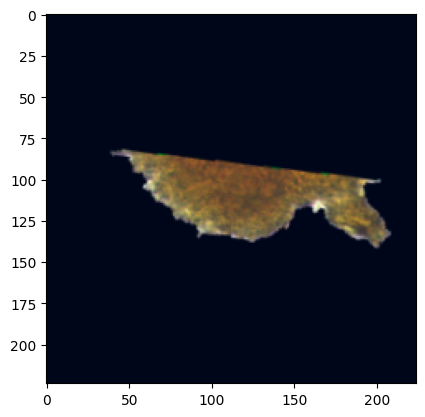

In [107]:
# visualize images from the trainset

print("Number of images:", len(trainset))
image, target = trainset[1] # it executes getitem
image     = image.permute(1,2,0).numpy()
image     = 255*(image - np.min(image))/(np.max(image)-np.min(image))
image     = image.astype('uint8')
print("Images are {}x{}x{}".format(width,height,nchannels))
plt.imshow(image)
print("Class of the image: ", target+1)
plt.show()

### Generate batches with batchsize images at random

In [108]:
batchsize = 32
trainload = DataLoader(trainset, batch_size=batchsize, shuffle=True)
testload  = DataLoader(testset, batch_size=batchsize, shuffle=True)
validload = DataLoader(validset, batch_size=batchsize, shuffle=True)

next(iter(trainload)) # inspect next item in the trainload

[tensor([[[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
           [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
           [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
           ...,
           [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
           [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
           [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],
 
          [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
           [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
           [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
           ...,
           [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
           [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
           [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],
 
          [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044],
           [-

### ConvNet model

In [109]:
# a convolutional block
def conv_block(nchannels_in, nchannels_out, stride_val):
    return nn.Sequential(
        #defining convolutional layer 
        nn.Conv2d(in_channels=nchannels_in, out_channels=nchannels_out, kernel_size=(3, 3),
                  stride=1, padding=1, bias=False),
        #defining a batch normalization layer, which dismisses the need for bias in the previous conv layer
        nn.BatchNorm2d(num_features=nchannels_out),
        #defining activation layer
        nn.ReLU(),
        #defining a pooling layer
        nn.MaxPool2d(kernel_size=(3, 3), stride=stride_val, padding=1)
    )

class CorelNet(nn.Module):

    def __init__(self, input_shape, num_classes):
        super(CorelNet, self).__init__()
        
        #defining feature extractor
        self.features = nn.Sequential(
            conv_block(input_shape[0],8,2),
            conv_block(8,16,2)
        )

        #defining classifier
        self.classifier = nn.Sequential(
            nn.Linear(in_features=input_shape[1]//4*input_shape[2]//4*16, out_features=16, bias=True),
            nn.ReLU(),
            nn.Linear(16, nclasses)
        )

        #initialize weights
        self._initialize_weights()

    def forward(self, x):
       #extracts features
        x = self.features(x)

        #transforms outputs into a 2D tensor
        x = torch.flatten(x, start_dim=1)

        #classifies features
        y = self.classifier(x)
  
        return y
  
    def _initialize_weights(self):
        #for each submodule of our network
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                #get the number of elements in the layer weights
                n = m.kernel_size[0] * m.kernel_size[1] * m.in_channels    
                #initialize layer weights with random values generated from a normal
                #distribution with mean = 0 and std = sqrt(2. / n))
                m.weight.data.normal_(mean=0, std=math.sqrt(2. / n))

                if m.bias is not None:
                    #initialize bias with 0 
                    m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                #initialize layer weights with random values generated from a normal
                #distribution with mean = 0 and std = 1/100
                m.weight.data.normal_(mean=0, std=0.01)
                if m.bias is not None:
                #initialize bias with 0 
                    m.bias.data.zero_()

### Create the model

In [110]:
model = CorelNet(input_shape, nclasses).to(device)
summary(model,input_size=(1, *input_shape))

Layer (type:depth-idx)                   Output Shape              Param #
CorelNet                                 [1, 2]                    --
├─Sequential: 1-1                        [1, 16, 56, 56]           --
│    └─Sequential: 2-1                   [1, 8, 112, 112]          --
│    │    └─Conv2d: 3-1                  [1, 8, 224, 224]          216
│    │    └─BatchNorm2d: 3-2             [1, 8, 224, 224]          16
│    │    └─ReLU: 3-3                    [1, 8, 224, 224]          --
│    │    └─MaxPool2d: 3-4               [1, 8, 112, 112]          --
│    └─Sequential: 2-2                   [1, 16, 56, 56]           --
│    │    └─Conv2d: 3-5                  [1, 16, 112, 112]         1,152
│    │    └─BatchNorm2d: 3-6             [1, 16, 112, 112]         32
│    │    └─ReLU: 3-7                    [1, 16, 112, 112]         --
│    │    └─MaxPool2d: 3-8               [1, 16, 56, 56]           --
├─Sequential: 1-2                        [1, 2]                    --
│    └─Line

### Define the loss function with L2 regularization

In [111]:
def Criterion(model, preds, targets):
    ce            = nn.CrossEntropyLoss().to(device)
    loss          = ce(preds, targets.long()) 
    # add l2_regularization            
    l2_regularization = 0
    for param in model.parameters():
        l2_regularization += torch.norm(param,2)
    loss += 0.0001*l2_regularization # 0.0001 is the weight_decay
    # compute mean accuracy in the batch
    pred_labels   = torch.max(preds, 1)[1] # same as argmax
    acc           = torch.sum(pred_labels == targets.data)
    n             = pred_labels.size(0)
    acc           = acc/n
    return loss, acc


criterion = Criterion

### Define optimizer and learning scheduler

In [112]:
optimizer    = optim.Adam(model.parameters(), lr=1e-5,weight_decay=1e-4)
# gamma=0.1 is a multiplicative factor for lr decay at every epoch
lr_scheduler = optim.lr_scheduler.ExponentialLR(optimizer, 0.1)
# gamma=0.1 is a multiplicative factor for lr decay at every step_size=number of epochs
# lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=25, gamma=0.1)

In [113]:
# Optimize model and optimizer for Intel hardware using IPEX
# model, optimizer = ipex.optimize(model, optimizer=optimizer, dtype=None, inplace=True)

### Clean up memory if needed

In [114]:
import gc
#del trainset, validset, testset
gc.collect()
torch.cuda.empty_cache()

### Define training and validation functions

In [115]:
def train_batch(model, data, optimizer, criterion, device):
    model.train()
    ims, targets = data
    ims     = ims.to(device=device)
    targets = targets.to(device=device)
    preds   = model(ims)
    loss, acc = criterion(model, preds, targets)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    return loss.item(), acc.item()

@torch.no_grad()
def validate_batch(model, data, criterion, device):
    model.eval()
    ims, targets = data
    ims     = ims.to(device=device)
    targets = targets.to(device=device)
    preds   = model(ims)
    loss, acc = criterion(model, preds, targets)
    return loss.item(), acc.item()

### Train the model and report the results

In [116]:
# initializing variables
n_epochs = 50
log      = Report(n_epochs)

# starting training and validation
for ex in range(n_epochs):
    N = len(trainload)
    for bx, data in enumerate(trainload):
        loss, acc = train_batch(model, data, optimizer, criterion, device)
        #report results for the batch
        log.record((ex+(bx+1)/N), trn_loss=loss, trn_acc=acc, end='\r')

    N = len(validload)
    for bx, data in enumerate(validload):
        loss, acc = validate_batch(model, data, criterion, device)
        log.record((ex+(bx+1)/N), val_loss=loss, val_acc=acc, end='\r')

    if (ex+1)%10==0: log.report_avgs(ex+1)
    #count epochs for auto-adjusting the learning rate
    lr_scheduler.step()

EPOCH: 10.000  trn_loss: 0.688  trn_acc: 0.596  val_loss: 0.697  val_acc: 0.414  (19.09s - 76.37s remaining)
EPOCH: 20.000  trn_loss: 0.690  trn_acc: 0.539  val_loss: 0.691  val_acc: 0.587  (36.83s - 55.25s remaining)
EPOCH: 30.000  trn_loss: 0.695  trn_acc: 0.450  val_loss: 0.692  val_acc: 0.502  (54.48s - 36.32s remaining)
EPOCH: 40.000  trn_loss: 0.689  trn_acc: 0.581  val_loss: 0.693  val_acc: 0.518  (72.08s - 18.02s remaining)
EPOCH: 50.000  trn_loss: 0.688  trn_acc: 0.560  val_loss: 0.698  val_acc: 0.403  (89.83s - 0.00s remaining)


### Plot the results

100%|███████████████████████████████████████| 151/151 [00:00<00:00, 5217.14it/s]


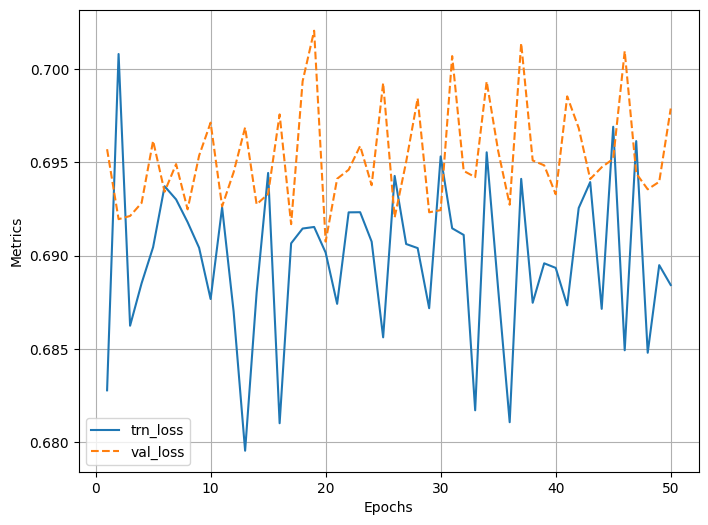

100%|███████████████████████████████████████| 151/151 [00:00<00:00, 7202.12it/s]


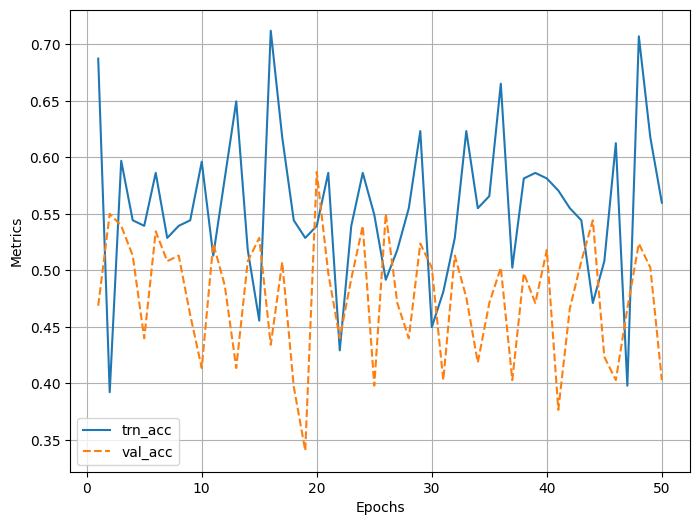

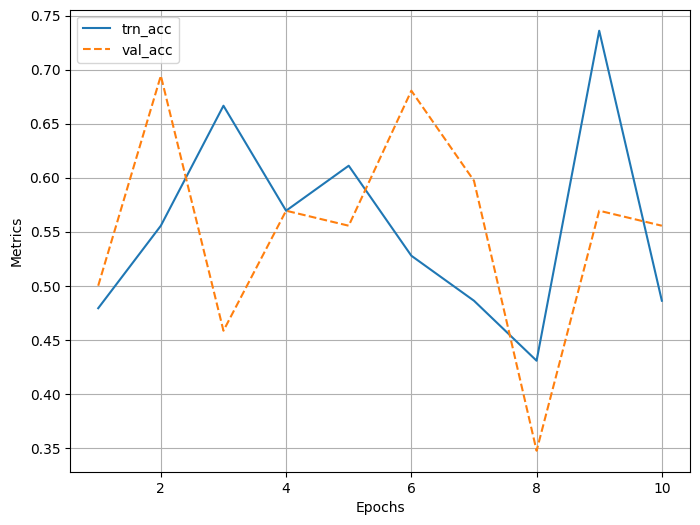

In [117]:
log.plot_epochs(['trn_loss','val_loss'])
log.plot_epochs(['trn_acc','val_acc'])

### Evaluate the model

In [118]:
def Test(model, testload, criterion, device):
    N = len(testload)
    mean_loss = 0
    mean_acc  = 0
    for bx, data in enumerate(testload):
        loss, acc  = validate_batch(model, data, criterion, device)
        mean_loss += loss
        mean_acc  += acc
    mean_loss = mean_loss / N
    mean_acc  = mean_acc / N
    return(mean_loss, mean_acc)

(loss, acc) = Test(model, testload, criterion, device)
print('Loss: {:.6f} Acc: {:.6f}'.format(loss,acc))

Loss: 0.694012 Acc: 0.544408


### Cohen's Kappa statistics

In [119]:
# Cohen's Kappa statistics

def Kappa(model, testload, device):
    model.eval()
    y_true = []
    y_pred = []
    for data in testload:
        ims, targets = data
        ims     = ims.to(device=device)
        targets = targets.to(device=device)
        preds   = model(ims)
        pred_labels = torch.max(preds, 1)[1] # same as argmax
        y_true.extend(targets.cpu().numpy())
        y_pred.extend(pred_labels.cpu().numpy())
    
    kappa = cohen_kappa_score(y_true, y_pred)
    return kappa

kappa = Kappa(model, testload, device)
print('Kappa: {:.6f}'.format(kappa*100))

Kappa: 8.144088


In [120]:
model.eval()
y_true = []
y_pred = []

for data in testload:
    ims, targets = data
    print("ims", ims)
    breakpoint()
    ims     = ims.to(device=device)
    targets = targets.to(device=device)
    preds   = model(ims)
    pred_labels = torch.max(preds, 1)[1] # same as argmax
    y_true.extend(targets.cpu().numpy())
    y_pred.extend(pred_labels.cpu().numpy())

ims tensor([[[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          ...,
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],

         [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          ...,
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],

         [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044],
          [-1.8044, -1.804

In [121]:
# Count the number of samples per class in the training set

from collections import Counter

total_counts = Counter()

for _, targets in trainload:
    total_counts.update(targets.cpu().numpy())

print("Total counts per class in the training set:", total_counts)


Total counts per class in the training set: Counter({np.int64(1): 27, np.int64(0): 24})


### Save the model

In [122]:
#torch.save(model.to('cpu').state_dict(), model_name)

#### Exercise: Play with optimizers, network architecture and hyperparameters to improve results without underfitting and overfitting. Note that you are using data augmentation, which might requires more epochs and lower learning rates for convergence. Verify preprocessing with no data augmentation and less training samples with data augmentation. 

### Visualize activations at the output of the last convolutional block for a given image

In [123]:
image, target = trainset[0]
image.size()

torch.Size([3, 224, 224])

In [124]:
image   = image.unsqueeze(0).to(device)

In [125]:
def get_corelnet_feature_map(model, input_tensor: torch.Tensor) -> torch.Tensor:
    """
    Simple method: Extract feature map by calling model.features directly
    
    Args:
        model: CorelNet model instance  
        input_tensor: Input tensor
    
    Returns:
        Feature map from the feature extractor (before flattening)
    """
    model.eval()
    with torch.no_grad():
        feature_map = model.features(input_tensor)
    return feature_map

In [126]:
def visualize_corelnet_features(feature_map: torch.Tensor, 
                               max_channels: int = 16,
                               start_channel: int = 0,
                               figsize: tuple = (15, 10),
                               sample_idx: int = 0):
    """
    Visualize CorelNet feature maps
    
    Args:
        feature_map: Feature map tensor (batch_size, channels, height, width)
        max_channels: Maximum number of channels to display
        start_channel: Starting channel index (0-based)
        figsize: Figure size for matplotlib
        sample_idx: Which sample from the batch to visualize
    """
    if feature_map.dim() == 4:
        feature_map_sample = feature_map[sample_idx]  # Shape: (channels, height, width)
    else:
        feature_map_sample = feature_map
    
    total_channels = feature_map_sample.shape[0]
    end_channel = min(start_channel + max_channels, total_channels)
    num_channels = end_channel - start_channel
    
    if start_channel >= total_channels:
        raise ValueError(f"start_channel ({start_channel}) must be less than total channels ({total_channels})")
    
    print(f"Feature map shape: {feature_map.shape}")
    print(f"Total channels: {total_channels}")
    print(f"Visualizing channels {start_channel}-{end_channel-1} from sample {sample_idx}")
    
    
    # Calculate grid dimensions
    cols = 4
    rows = (num_channels + cols - 1) // cols
    
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    if rows == 1:
        axes = axes.reshape(1, -1)
    axes = axes.flatten()
    
    for i in range(num_channels):
        ax = axes[i]
        channel_idx = start_channel + i
        channel_data = feature_map_sample[channel_idx].cpu().numpy()
        
        im = ax.imshow(channel_data, cmap='viridis')
        ax.set_title(f'Channel {channel_idx}\nMin: {channel_data.min():.2f}\nMax: {channel_data.max():.2f}', 
                    fontsize=10)
        ax.axis('off')
        plt.colorbar(im, ax=ax, shrink=0.6)
    
    # Hide unused subplots
    for i in range(num_channels, len(axes)):
        axes[i].axis('off')
    
    plt.suptitle(f'CorelNet Feature Maps - Channels {start_channel}-{end_channel-1}\nShape: {feature_map.shape}', 
                 fontsize=14)
    plt.tight_layout()
    plt.show()

Feature map shape: torch.Size([1, 16, 56, 56])
Total channels: 16
Visualizing channels 8-15 from sample 0


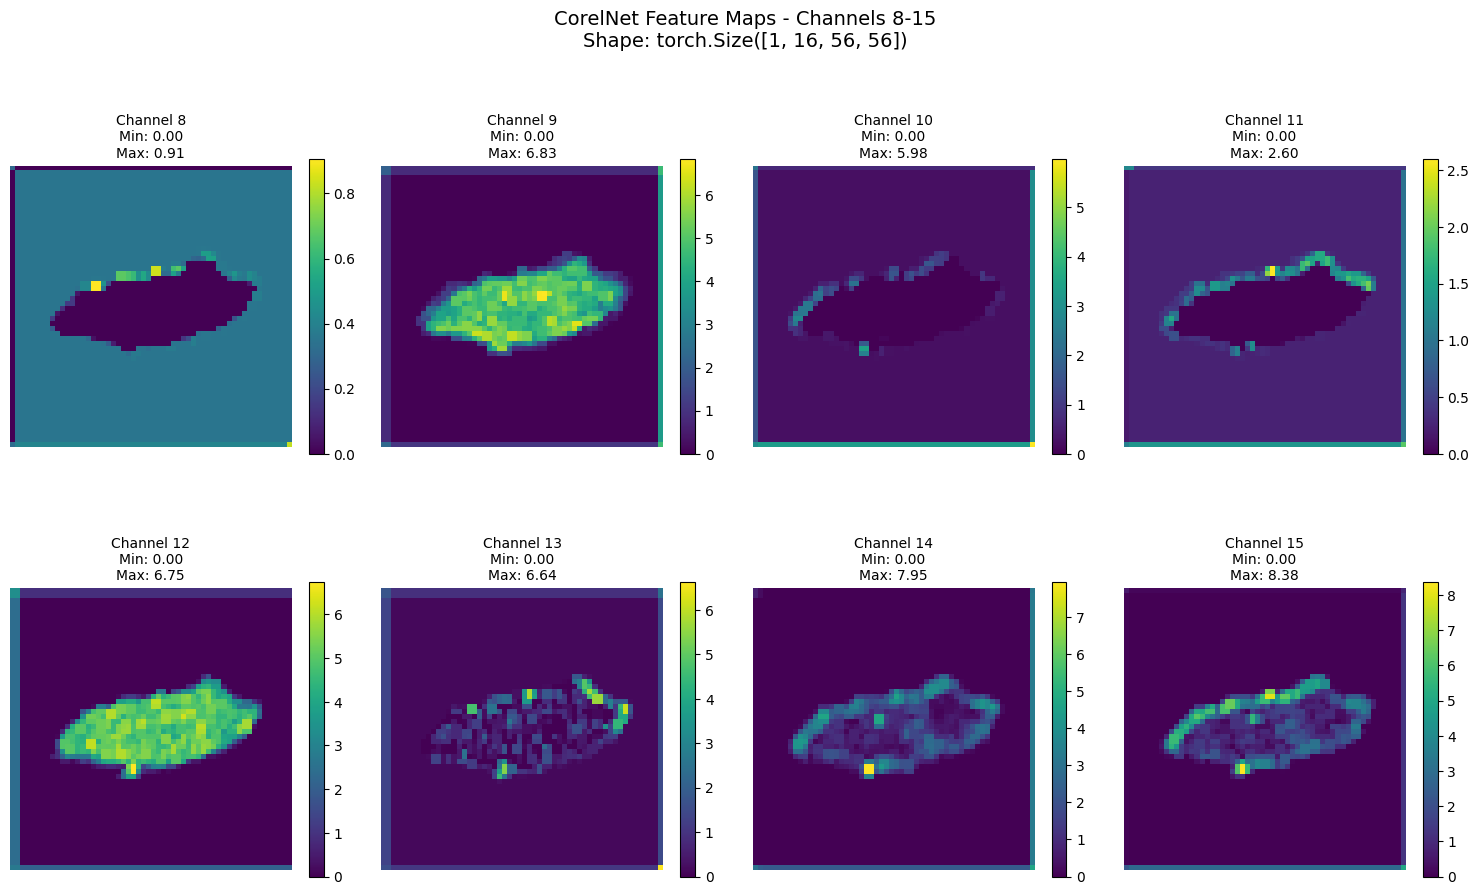

In [128]:
featmap = get_corelnet_feature_map(model,image)
visualize_corelnet_features(featmap, max_channels=8, start_channel=8)

### Visualizar as projeções tSNE/UMAP da última camada convolucional e das camadas densas

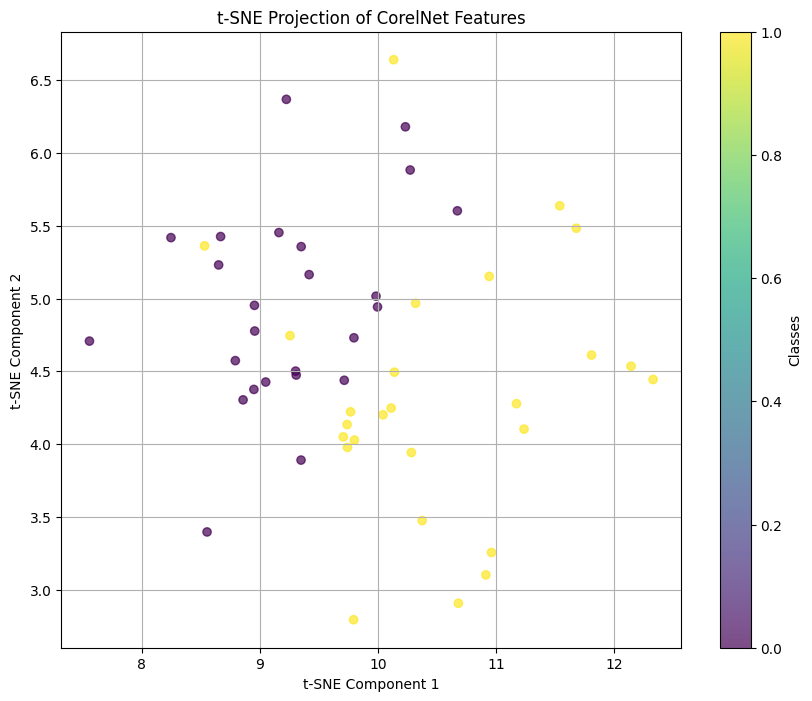

In [129]:
# tSNE Projection

from sklearn.manifold import TSNE

def tsne_projection(model, dataloader, device, n_components=2, perplexity=30, n_iter=1000):
    model.eval()
    with torch.no_grad():
        features = []
        labels = []
        for inputs, targets in dataloader:
            inputs = inputs.to(device)
            outputs = model.features(inputs)
            features.append(outputs.cpu())
            labels.append(targets.cpu())
    features = torch.cat(features, dim=0)
    labels = torch.cat(labels, dim=0)

    tsne = TSNE(n_components=n_components, perplexity=perplexity)
    reduced_features = tsne.fit_transform(features.reshape(features.size(0), -1).numpy())
    return reduced_features, labels.numpy()

reduced_features, labels = tsne_projection(model, testload, device, n_components=2, perplexity=30)
plt.figure(figsize=(10, 8))
scatter = plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=labels, cmap='viridis', alpha=0.7)
plt.colorbar(scatter, label='Classes')
plt.title('t-SNE Projection of CorelNet Features')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.grid()
plt.show()

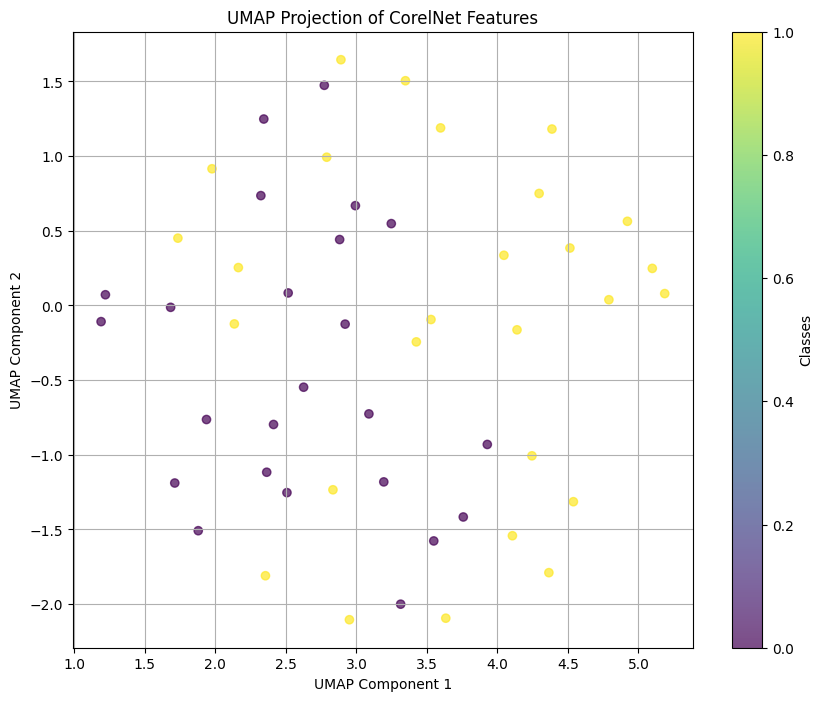

In [130]:
# Using UMAP for dimensionality reduction

import umap

def umap_projection(model, dataloader, device, n_components=2, n_neighbors=15, min_dist=0.1):
    model.eval()
    with torch.no_grad():
        features = []
        labels = []
        for inputs, targets in dataloader:
            inputs = inputs.to(device)
            outputs = model.features(inputs)
            features.append(outputs.cpu())
            labels.append(targets.cpu())
    features = torch.cat(features, dim=0)
    labels = torch.cat(labels, dim=0)

    reducer = umap.UMAP(n_components=n_components, n_neighbors=n_neighbors, min_dist=min_dist)
    #reduced_features = reducer.fit_transform(features.view(features.size(0), -1).numpy())
    reduced_features = reducer.fit_transform(features.reshape(features.size(0), -1).numpy())
    return reduced_features, labels.numpy()

reduced_features_umap, labels_umap = umap_projection(model, trainload, device, n_components=2, n_neighbors=15, min_dist=0.1)
plt.figure(figsize=(10, 8))
scatter_umap = plt.scatter(reduced_features_umap[:, 0], reduced_features_umap[:, 1], c=labels_umap, cmap='viridis', alpha=0.7)
plt.colorbar(scatter_umap, label='Classes')
plt.title('UMAP Projection of CorelNet Features')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.grid()
plt.show()